In [1]:
# Necessary imports
import findspark
findspark.init() # Find Spark installation

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType, BooleanType, TimestampType, StructType, StructField

# For ML tasks (even if demonstrating MapReduce concepts, preprocessing often uses MLlib)
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix # For potential matrix operations

import math
import heapq
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors




In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [ ]:
from pyspark.sql.functions import hour, dayofweek, month, year, when

df = df.withColumn("hour_of_day", hour(df["Start_Time"]))
df = df.withColumn("day_of_week", dayofweek(df["Start_Time"]))
df = df.withColumn("month", month(df["Start_Time"]))
df = df.withColumn("year", year(df["Start_Time"]))

df = df.withColumn("weather_condition_cat", when(df["Weather_Condition"] == "Clear", 0)
                                            .when(df["Weather_Condition"] == "Rain", 1)
                                            .when(df["Weather_Condition"] == "Snow", 2)
                                            .otherwise(3))

df = df.withColumn("is_night", when((df["hour_of_day"] >= 18) | (df["hour_of_day"] < 6), 1).otherwise(0))

df = df.withColumn("severe_accident", when(df["Severity"] >= 3, 1).otherwise(0))


df.show(5)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+-----+----+---------------------+--------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visib

In [ ]:
from functools import reduce
from pyspark.sql import DataFrame
target_col = "severe_accident"

def undersample_to_target(df, target_col):
    class_counts = df.groupBy(target_col).count().collect()
    target_count = min([row["count"] for row in class_counts])
    
    balanced_dfs = []
    for class_value in df.select(target_col).distinct().collect():
        class_df = df.filter(df[target_col] == class_value[target_col])
        fraction = target_count / class_df.count()
        sampled_df = class_df.sample(withReplacement=False, fraction=fraction, seed=42)
        balanced_dfs.append(sampled_df)
    
    balanced_df = reduce(DataFrame.union, balanced_dfs)
    return balanced_df

df = undersample_to_target(df, target_col)

new_counts = df.groupBy(target_col).count().collect()
print("New class distribution after undersampling:")
for row in new_counts:
    print(row)

New class distribution after undersampling:
Row(severe_accident=1, count=1504047)
Row(severe_accident=0, count=1505074)


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

df = df.dropna(subset=["Severity"])


In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

logistic_features = ["hour_of_day", "day_of_week", "month", "Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed", "is_night", "weather_condition_cat"]
assembler = VectorAssembler(inputCols=logistic_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

lr_model = LogisticRegression(labelCol="severe_accident", featuresCol="features")
model = lr_model.fit(train_data)

logistic_predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

precision_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(logistic_predictions)
recall = recall_evaluator.evaluate(logistic_predictions)
f1 = f1_evaluator.evaluate(logistic_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Logistic Regression Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1-Score: 0.55


In [ ]:
predictions_df = logistic_predictions.select("severe_accident", "prediction").toPandas()

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(predictions_df["severe_accident"], predictions_df["prediction"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Severe", "Severe"], yticklabels=["Non-Severe", "Severe"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

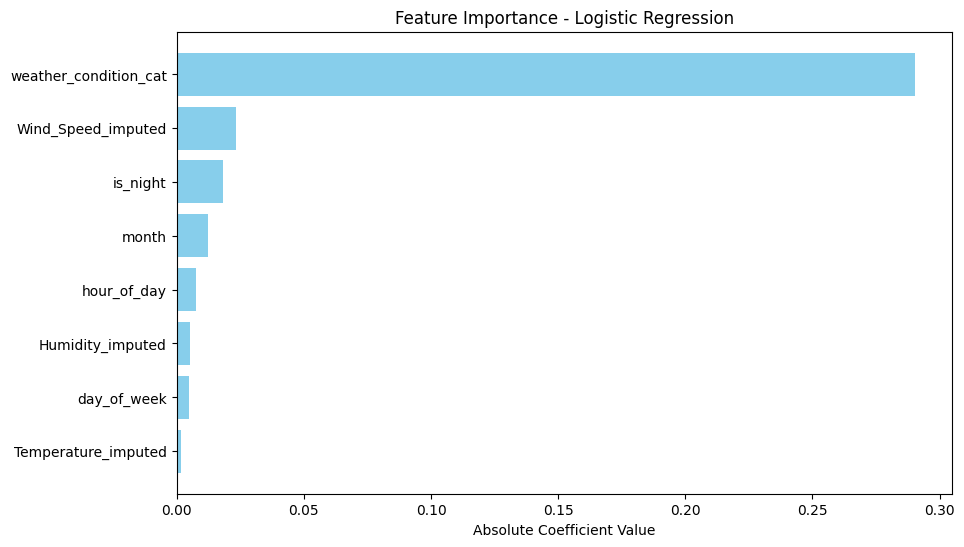

                 Feature  Coefficient
7  weather_condition_cat    -0.290270
4     Wind_Speed_imputed     0.023321
6               is_night     0.018237
2                  month    -0.012177
0            hour_of_day     0.007413
5       Humidity_imputed     0.005141
1            day_of_week    -0.004697
3    Temperature_imputed     0.001640


In [ ]:
from pyspark.ml.classification import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

coefficients = model.coefficients.toArray()
intercept = model.intercept
features = logistic_features

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df[['Feature', 'Coefficient']])

